In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
import os

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Load the data 載入資料</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Dataset Information 資料集資訊</div>

### Metadata
- Name 資料集名稱: DAIGT V2 Train Dataset
- Link 資料集連結: [DAIGT V2 Train Dataset](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset)
- Sample Size 樣本數: 44868

### Columns
- `text` : The text of the essay 文章內容
- `label` : The label of the essay 1 for AI generated, 0 for human written 文章標籤，1 代表 AI 生成，0 代表人類撰寫
- `prompt_name` : The original persuade prompt 原始說服指示名稱
- `source` : The source dataset 文章來源資料集
- `RDizzl3_seven` : For filtering purposes 用於篩選目的

### Description (From Kaggle)

New release of DAIGT train dataset! Improvement:

- new models: Cohere Command, Google Palm, GPT4 (from Radek!)
- new prompts, including source texts from the original essays!
- mapping of essay text to original prompt from persuade corpus
- filtering by the famous "RDizzl3_seven"


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the data from CSV file 載入 CSV 檔案</div>

In [46]:
df = pd.read_csv('../data/DAIGT V2 Train Dataset.csv')
df.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Data Exploration 資料探索</div>

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


The dataset contains 44868 rows and 5 columns. There are no missing values in the dataset.

該資料集包含 44868 行和 5 列。資料集中沒有缺失值。

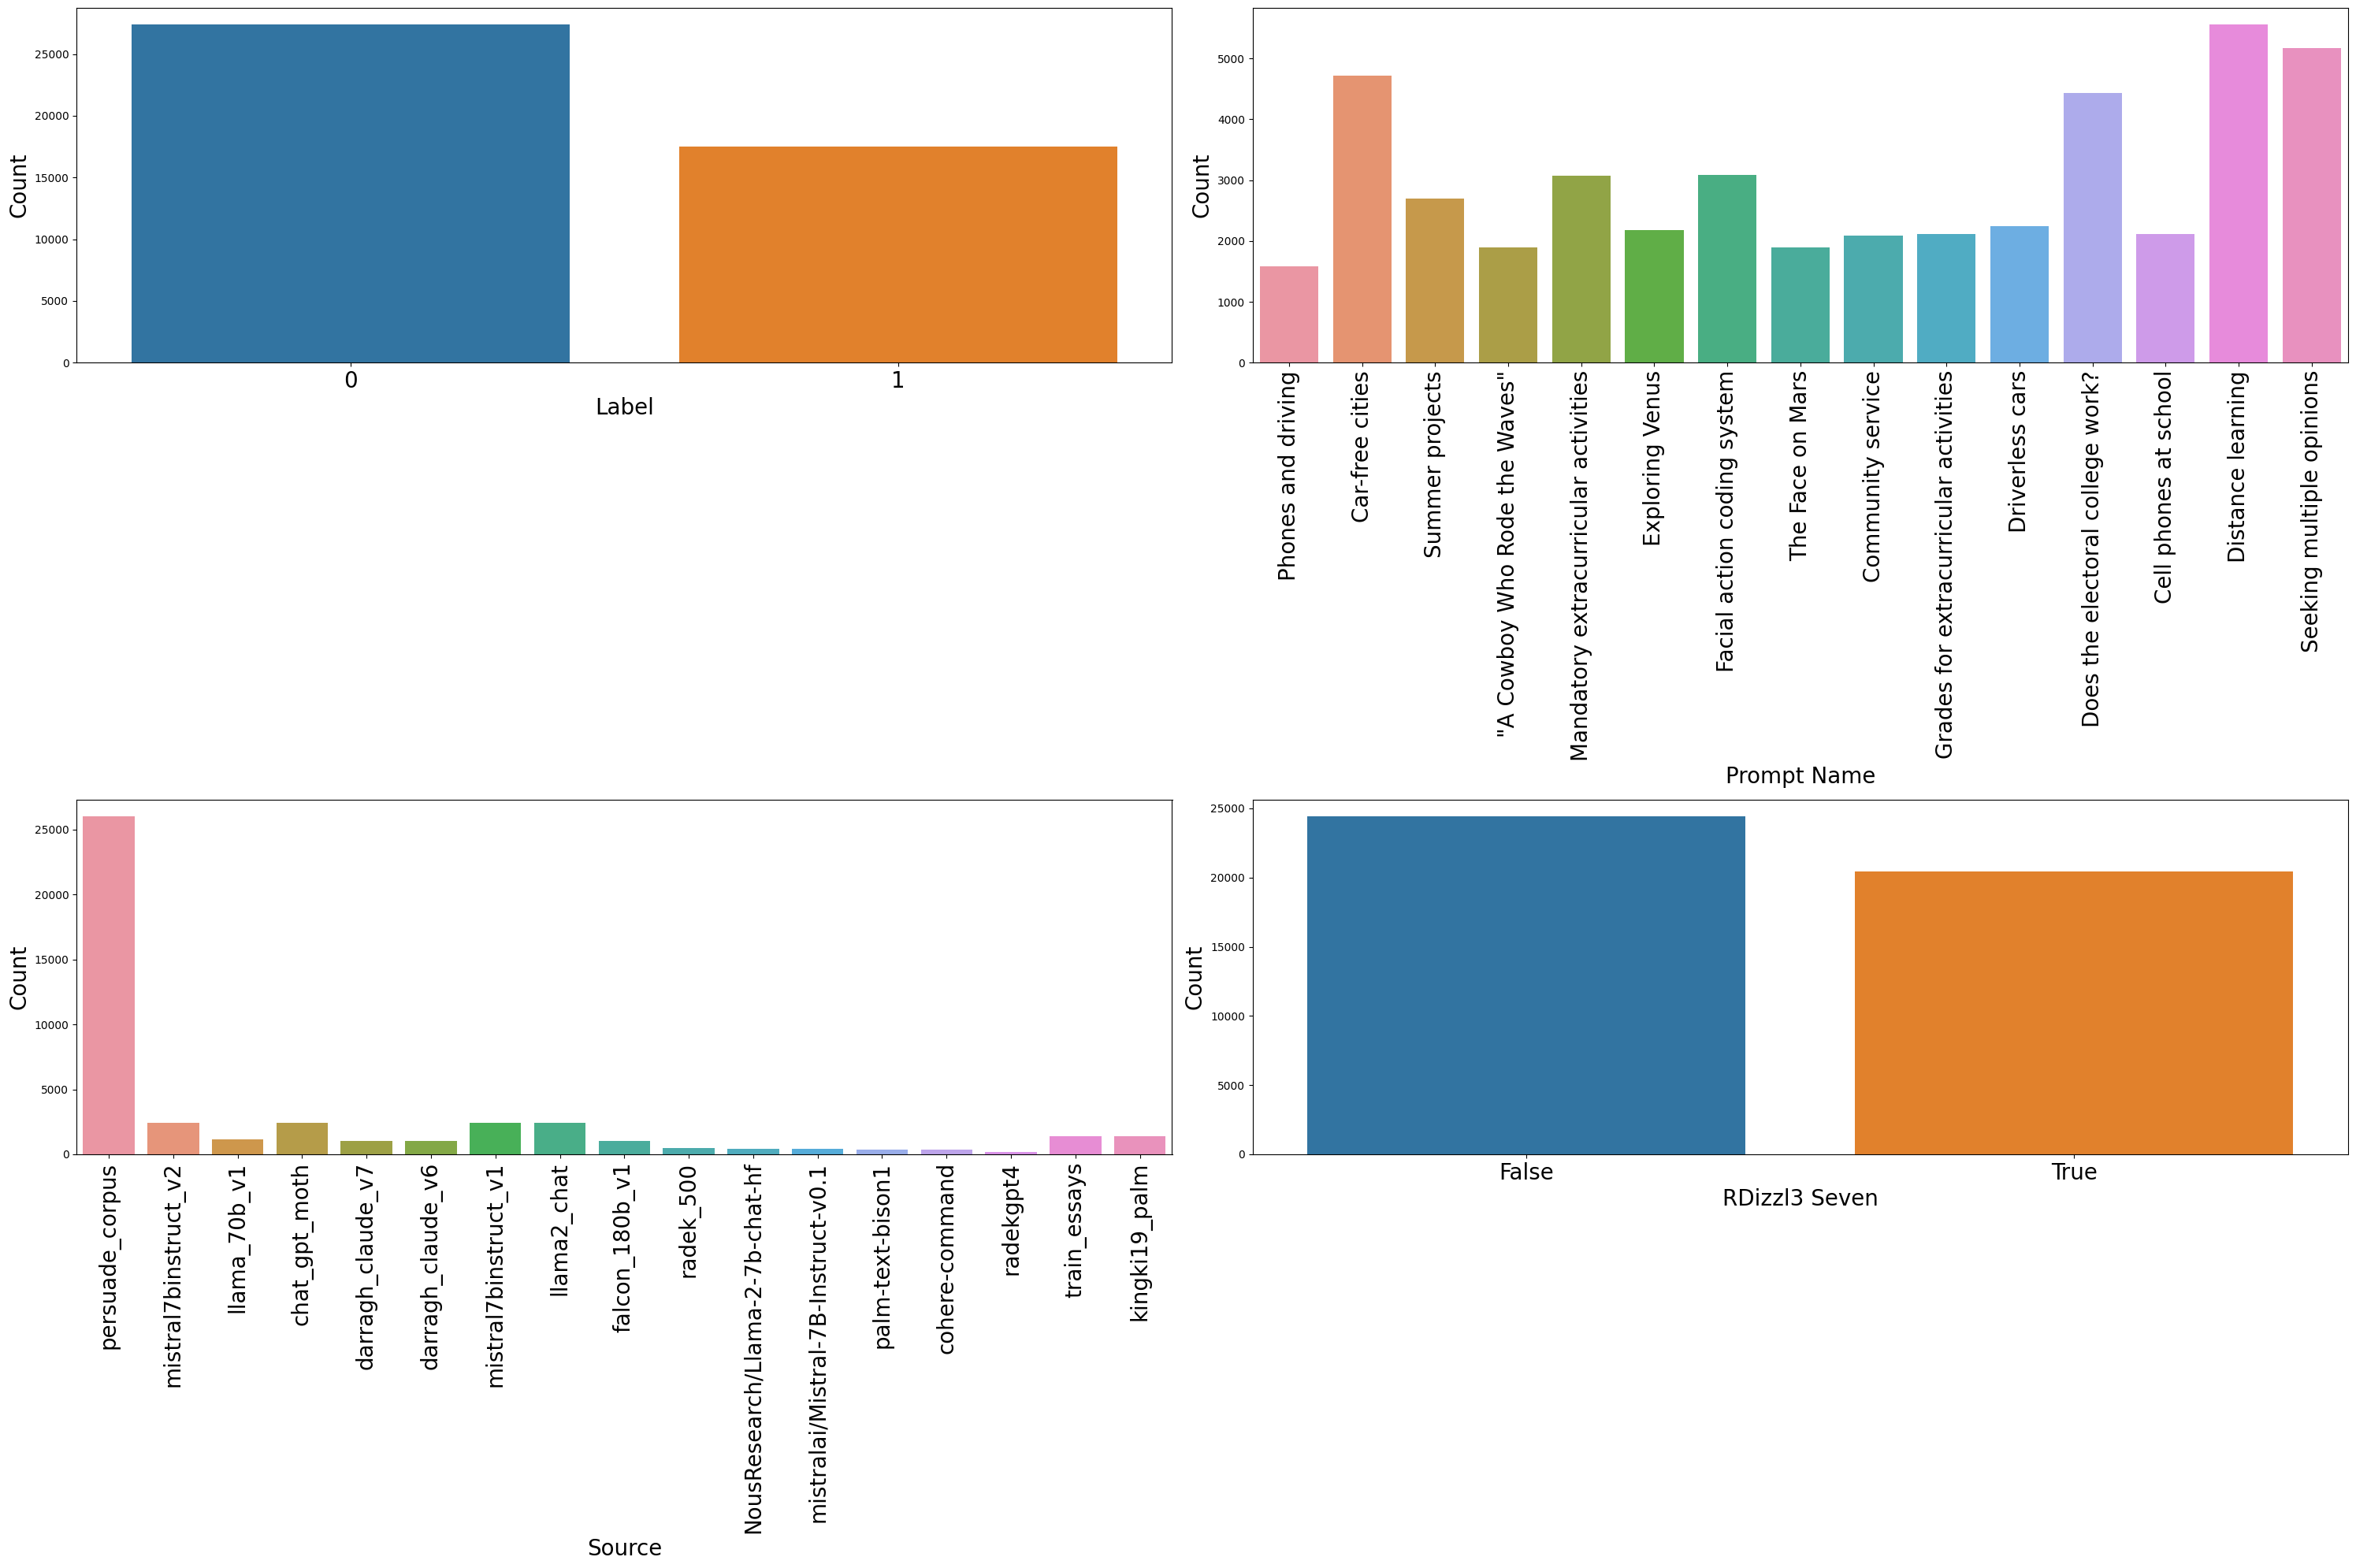

In [48]:
# Check for unique values in each column
fig, ax = plt.subplots(2, 2, figsize=(30, 20))

sns.countplot(x='label', data=df, ax=ax[0, 0])
ax[0, 0].tick_params(axis='x', labelsize=20)
ax[0, 0].set_xlabel('Label', fontsize=20)
ax[0, 0].set_ylabel('Count', fontsize=20)

sns.countplot(x='prompt_name', data=df, ax=ax[0, 1])
ax[0, 1].tick_params(axis='x', rotation=90, labelsize=20)
ax[0, 1].set_xlabel('Prompt Name', fontsize=20)
ax[0, 1].set_ylabel('Count', fontsize=20)

sns.countplot(x='source', data=df, ax=ax[1, 0])
ax[1, 0].tick_params(axis='x', rotation=90, labelsize=20)
ax[1, 0].set_xlabel('Source', fontsize=20)
ax[1, 0].set_ylabel('Count', fontsize=20)

sns.countplot(x='RDizzl3_seven', data=df, ax=ax[1, 1])
ax[1, 1].tick_params(axis='x', labelsize=20)
ax[1, 1].set_xlabel('RDizzl3 Seven', fontsize=20)
ax[1, 1].set_ylabel('Count', fontsize=20)

plt.tight_layout()
plt.show()

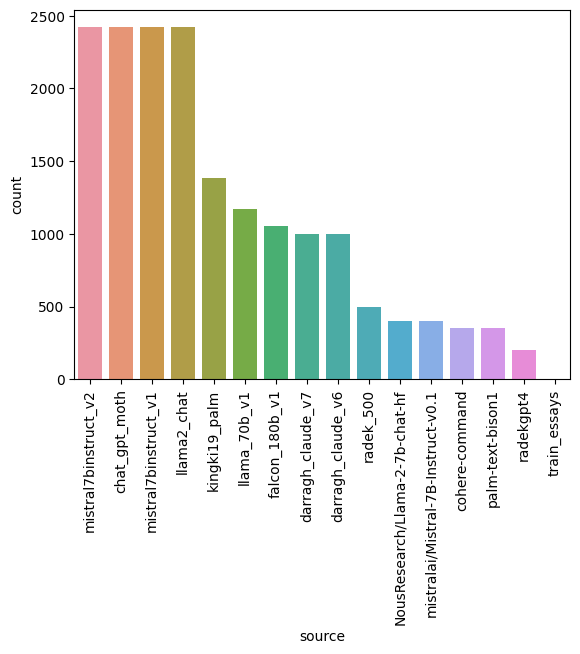

In [49]:
# Check distribution of the Source column for AI generated
subset = df[df['label'] == 1]
sns.countplot(x='source', data=subset, order=subset['source'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

- mistral7b/instruct_v2: 出現最多，約2500次。
- chat_gpt_moth: 與 mistral7b/instruct_v2 相同，約2500次。
- mistral7b/instruct_v1: 也與 mistral7b/instruct_v2 相同，約2500次。
- llama2_chat: 稍微少一些，約2000次。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Data Preprocessing 資料前處理</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Split the data into training and testing 分割資料集為訓練集和測試集</div>

In [51]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_df.shape, val_df.shape

((40381, 5), (4487, 5))

我們可以看到訓練集有 40381 行，驗證集有 4487 行。

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Check split distribution 檢查分割分佈</div>

In [52]:
train_df['label'].value_counts(normalize=True)

label
0    0.611055
1    0.388945
Name: proportion, dtype: float64

In [53]:
val_df['label'].value_counts(normalize=True)

label
0    0.600847
1    0.399153
Name: proportion, dtype: float64

可以看到訓練集和驗證集中 AI 生成和人類撰寫的文章比例相似。

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Create Hugging Face Datasets 創建 Hugging Face 資料集</div>

In [54]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [55]:
train_dataset

Dataset({
    features: ['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven', '__index_level_0__'],
    num_rows: 40381
})

In [56]:
val_dataset

Dataset({
    features: ['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven', '__index_level_0__'],
    num_rows: 4487
})

In [57]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'prompt_name': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'RDizzl3_seven': Value(dtype='bool', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [58]:
val_dataset.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'prompt_name': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'RDizzl3_seven': Value(dtype='bool', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Save the datasets 儲存資料集</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Save the datasets to disk 儲存資料集到磁碟</div>

In [59]:
train_dataset.save_to_disk('data/train_dataset')
val_dataset.save_to_disk('data/val_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/40381 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4487 [00:00<?, ? examples/s]

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the datasets from disk 從磁碟載入資料集</div>

In [2]:
train_dataset = Dataset.load_from_disk('data/train_dataset')
val_dataset = Dataset.load_from_disk('data/val_dataset')

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Load the transformer model 載入 Transformer 模型</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Select the model 選擇模型</div>

### Roberta

在這個 notebook 中，我們將使用 Hugging Face Roberta 模型進行文本分類任務。

- 模型名稱: `roberta-base`
- 模型類型: Transformer
- 模型架構: RoBERTa (Robustly optimized BERT approach)

In [3]:
model_name = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: Encode the text data 編碼文本數據</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Use the tokenizer to encode the text data 使用 tokenizer 編碼文本數據</div>

In [4]:
def encode(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

# Encode the text data
train_dataset = train_dataset.map(encode, batched=True)
val_dataset = val_dataset.map(encode, batched=True)

# Set the format to PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Set up the training parameters and train the model 設置訓練參數並訓練模型</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up device 設置設備</div>

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [6]:
device

device(type='cuda')

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the training parameters 設置訓練參數</div>

In [7]:
# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Start training 開始訓練</div>

In [8]:
# 禁用 WandB
os.environ["WANDB_DISABLED"] = "true"

# Start training
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/1893 [00:00<?, ?it/s]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
